# NYC Taxi Fare Predictor

**Kaggle Prediction Competition**:                                        
[New York City Taxi Fare Prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction)  

**File descriptions**
- train.csv - Input features and target fare_amount values for the training set (about 55M rows).                     
- test.csv - Input features for the test set (about 10K rows). Your goal is to predict fare_amount for each row.                         
- sample_submission.csv - a sample submission file in the correct format (columns key and fare_amount). This file 'predicts' fare_amount to be 11.35 US dollar for all rows, which is the mean fare_amount from the training set.                                  

**Data fields** 
- key - Unique string identifying each row in both the training and test sets. Comprised of pickup_datetime plus a unique integer, but this doesn't matter, it should just be used as a unique ID field. Required in your submission CSV. Not necessarily needed in the training set, but could be useful to simulate a 'submission file' while doing cross-validation within the training set.                    

**Features**
- pickup_datetime - timestamp value indicating when the taxi ride started.           
- pickup_longitude - float for longitude coordinate of where the taxi ride started.                        
- pickup_latitude - float for latitude coordinate of where the taxi ride started.                           
- dropoff_longitude - float for longitude coordinate of where the taxi ride ended.                           
- dropoff_latitude - float for latitude coordinate of where the taxi ride ended.                             
- passenger_count - integer indicating the number of passengers in the taxi ride.       

**Target**                                      
- fare_amount - float dollar amount of the cost of the taxi ride. This value is only in the training set; this is what you are predicting in the test set and it is required in your submission CSV.                                      

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import modules
import gcsfs # necessary for reading csv from GCP storage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data sourcing

- train and test data are downloaded and stored in GCP storage
- let's start with first 1 million rows

In [3]:
%%time
# read the train.csv directly from GCP cloud storage
url = 'gs://nyc_taxifare_predictor/raw_data/train.csv'
df = pd.read_csv(url, nrows=1000000, encoding='utf-8')
df.head()

Wall time: 12.4 s


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
%%time
# read the test.csv directly from GCP cloud storage
url = 'gs://nyc_taxifare_predictor/raw_data/test.csv'
test = pd.read_csv(url, encoding='utf-8')
test.head()

Wall time: 621 ms


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


## Target exploration

In [5]:
# statistic summary of target variable: fare amount
df.fare_amount.describe()

count    1000000.000000
mean          11.348079
std            9.822090
min          -44.900000
25%            6.000000
50%            8.500000
75%           12.500000
max          500.000000
Name: fare_amount, dtype: float64

In [6]:
# drop non-realistic fare amounts
df = df[df.fare_amount.between(0, 1000)]
df.fare_amount.describe()

count    999962.000000
mean         11.348742
std           9.821550
min           0.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         500.000000
Name: fare_amount, dtype: float64

<AxesSubplot:xlabel='fare_amount', ylabel='Count'>

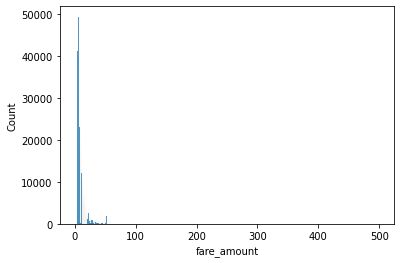

In [7]:
# check out the distribution of dare_amount
sns.histplot(df['fare_amount'])

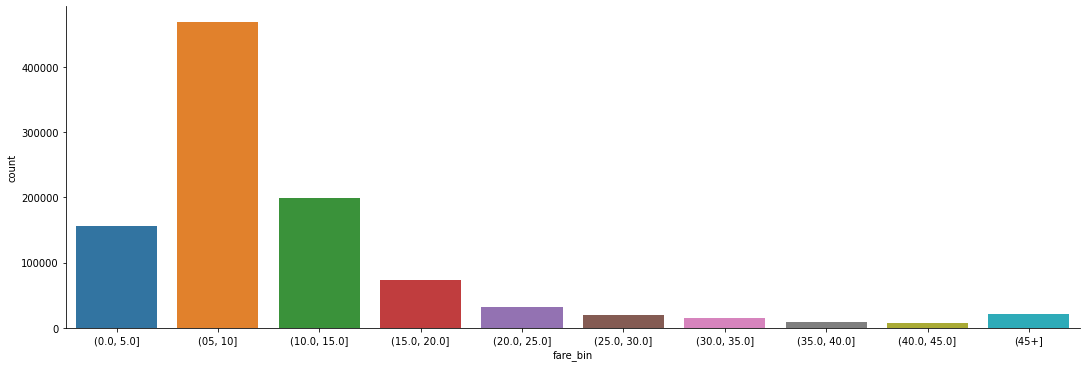

In [8]:
# create bins for fare amount
bins = [x for x in range(0, 50, 5)]
df['fare_bin'] = pd.cut(df.fare_amount, bins=bins).astype('str')
# adjust fare_bin and sort by fare_bin
df.loc[df.fare_bin=='(5.0, 10.0]', 'fare_bin'] = '(05, 10]'
df.loc[df.fare_bin=='nan', 'fare_bin'] = '(45+]'
df.sort_values('fare_bin', inplace=True)
# plot
sns.catplot(data=df, x='fare_bin', kind='count', height=5, aspect=3);

## Feature exploration

- let's first checkout which features are there and what are the datatypes

In [40]:
# check data types
df.drop(columns=['fare_amount', 'key', 'fare_bin']).dtypes

pickup_datetime      datetime64[ns, America/New_York]
pickup_longitude                              float64
pickup_latitude                               float64
dropoff_longitude                             float64
dropoff_latitude                              float64
passenger_count                                 int64
year                                            int64
month                                           int64
dayofweek                                       int64
hour                                            int64
hour_cos                                      float64
dayofweek_cos                                 float64
month_cos                                     float64
hour_sin                                      float64
dayofweek_sin                                 float64
month_sin                                     float64
dtype: object

### pickup_datetime

- let's first extract some features from pickup_datetime

In [42]:
df.pickup_datetime.dtypes

datetime64[ns, America/New_York]

In [11]:
# extract time features
def get_time_features(df):
    df.index = pd.to_datetime(df.pickup_datetime.str.replace(' UTC', ''), format='%Y-%m-%d %H:%M:%S')
    df.index = df.index.tz_localize('UTC').tz_convert('America/New_York')
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['dayofweek'] = df.index.weekday
    df['hour'] = df.index.hour
    df.drop('pickup_datetime', axis=1, inplace=True)
    return df.reset_index()

In [13]:
df = get_time_features(df)
df.head()

,pickup_datetime,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_bin,year,month,dayofweek,hour
0,2009-06-15 13:26:21-04:00,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,"(0.0, 5.0]",2009,6,0,13
1,2010-02-12 21:22:15-05:00,2010-02-13 02:22:15.0000006,4.5,-73.995530,40.744140,-74.000129,40.734766,1,"(0.0, 5.0]",2010,2,4,21
2,2011-03-25 15:17:57-04:00,2011-03-25 19:17:57.0000004,4.1,-73.955227,40.764276,-73.963834,40.761401,1,"(0.0, 5.0]",2011,3,4,15
3,2011-10-05 02:16:00-04:00,2011-10-05 06:16:00.00000029,4.9,-73.996563,40.743817,-73.987188,40.750105,3,"(0.0, 5.0]",2011,10,2,2
4,2010-01-15 12:13:00-05:00,2010-01-15 17:13:00.000000142,4.9,-73.960937,40.761060,-73.960550,40.768838,1,"(0.0, 5.0]",2010,1,4,12


In [35]:
# transform cyclical features
def transform_cyclical_features(df):
    cols=['hour','dayofweek', 'month']
    gap = df[cols].max()-df[cols].min()
    cos_cols = []
    sin_cols = []
    for col in cols:
        cos_col = col + '_cos'
        cos_cols.append(cos_col)
        sin_col = col + '_sin'
        sin_cols.append(sin_col)
    # cosine transfrom
    df[cos_cols] = np.cos(2*np.pi*df[cols]/gap)
    # sine transform
    df[sin_cols] = np.sin(2*np.pi*df[cols]/gap)
    return df  

In [36]:
df = transform_cyclical_features(df)
df.head()

,pickup_datetime,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_bin,year,month,dayofweek,hour,hour_cos,dayofweek_cos,month_cos,hour_sin,dayofweek_sin,month_sin
0,2009-06-15 13:26:21-04:00,2009-06-15 17:26:21.0000001,4.5,-73.844311,40.721319,-73.841610,40.712278,1,"(0.0, 5.0]",2009,6,0,13,-0.917211,1.0,-0.959493,-0.398401,0.000000,-0.281733
1,2010-02-12 21:22:15-05:00,2010-02-13 02:22:15.0000006,4.5,-73.995530,40.744140,-74.000129,40.734766,1,"(0.0, 5.0]",2010,2,4,21,0.854419,-0.5,0.415415,-0.519584,-0.866025,0.909632
2,2011-03-25 15:17:57-04:00,2011-03-25 19:17:57.0000004,4.1,-73.955227,40.764276,-73.963834,40.761401,1,"(0.0, 5.0]",2011,3,4,15,-0.576680,-0.5,-0.142315,-0.816970,-0.866025,0.989821
3,2011-10-05 02:16:00-04:00,2011-10-05 06:16:00.00000029,4.9,-73.996563,40.743817,-73.987188,40.750105,3,"(0.0, 5.0]",2011,10,2,2,0.854419,-0.5,0.841254,0.519584,0.866025,-0.540641
4,2010-01-15 12:13:00-05:00,2010-01-15 17:13:00.000000142,4.9,-73.960937,40.761060,-73.960550,40.768838,1,"(0.0, 5.0]",2010,1,4,12,-0.990686,-0.5,0.841254,-0.136167,-0.866025,0.540641


### locations

- Now, let's extract some features from geolocations

In [45]:
df[['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,999962.000000,999962.000000,999952.000000,999952.000000
mean,-72.526660,39.929017,-72.528101,39.920086
std,12.057945,7.626193,11.323777,8.201183
min,-3377.680935,-3116.285383,-3383.296608,-3114.338567
25%,-73.992060,40.734965,-73.991385,40.734047
50%,-73.981792,40.752695,-73.980135,40.753166
75%,-73.967095,40.767154,-73.963654,40.768129
max,2522.271325,2621.628430,45.581619,1651.553433


- latitude ranges from -90 to 90 and longitude ranges -180 to 180. Let's remove the non-realistic data points.

In [48]:
def lat_long_clean(df):
    df = df[df.pickup_longitude.between(-180, 180)]
    df = df[df.pickup_latitude.between(-90, 90)]
    df = df[df.dropoff_longitude.between(-180, 180)]
    df = df[df.dropoff_latitude.between(-90, 90)]
    return df

In [49]:
df = lat_long_clean(df)

In [52]:
df[['pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,999912.000000,999912.000000,999912.000000,999912.000000
mean,-72.517323,39.926754,-72.515465,39.925998
std,10.393533,6.089366,10.396548,6.093337
min,-128.175950,-74.016587,-121.391248,-74.035197
25%,-73.992060,40.734965,-73.991385,40.734047
50%,-73.981792,40.752695,-73.980135,40.753166
75%,-73.967095,40.767153,-73.963654,40.768128
max,40.850357,69.400000,45.581619,81.510177


#### distance

In [ ]:
# extract distance features

#### direction

### passenger

## Evaluation metric

## Baseline model

## Models